In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os
from collections import namedtuple
from celerite import GP
from celerite.terms import Matern32Term
import pymc3 as pm
from pymc3.smc import sample_smc
import theano
from corner import corner

from lightkurve import search_lightcurvefile

In [2]:
lcf = search_lightcurvefile("AB Dor", mission='TESS').download_all()
lc = lcf.PDCSAP_FLUX.stitch()

/opt/conda/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


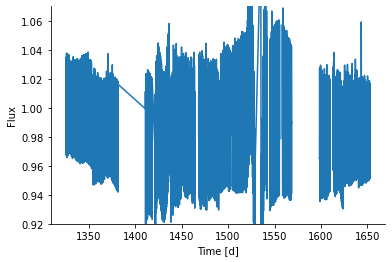

In [3]:
%matplotlib inline
plt.plot(lc.time, lc.flux)
# plt.xlim([1340, 1352])
plt.ylim([0.92, 1.07])
for sp in 'right top'.split():
    plt.gca().spines[sp].set_visible(False)
    
plt.gca().set(xlabel='Time [d]', ylabel='Flux')
plt.show()

In [4]:
t, f, e = lc.time[~np.isnan(lc.flux)], lc.flux[~np.isnan(lc.flux)], lc.flux_err[~np.isnan(lc.flux)]

In [5]:
mins = [1325, 1340, 1452, 1640]
maxs = [1339, 1353, 1464, 1653]

In [6]:
import pickle

def save_trace(name, trace): 
    with open(name, 'wb') as buff: 
        pickle.dump(trace, buff)

In [7]:
import logging 

class DisableLogger():
    def __enter__(self):
        logging.disable(logging.CRITICAL)
    def __exit__(self, a, b, c):
        logging.disable(logging.NOTSET)

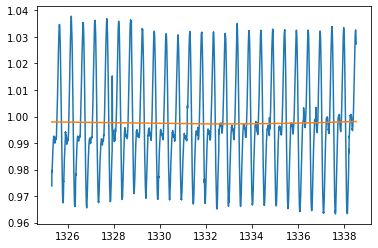

start SMC with 2 spots...


In [ ]:
traces = []

for i in range(0, len(mins)):
    max_time = maxs[i]
    min_time = mins[i]

    skip = 3

    t1, f1, e1 = t[(t < max_time) & (t > min_time)][::skip], f[(t < max_time) & (t > min_time)][::skip], e[(t < max_time) & (t > min_time)][::skip]

    if t1.ptp() > 0: 
        gp = GP(Matern32Term(log_sigma=1, log_rho=8))
        gp.compute(t1 / 100, e1)
        gp_trend = gp.predict(f1, t1 / 100,  return_cov=False)

        plt.plot(t1, f1)
        plt.plot(t1, gp_trend)

        f1 /= gp_trend
        plt.show()

        e1_tt = theano.shared(np.asarray(e1, dtype=theano.config.floatX), name='e1')

        n_spots = 2
        with DisableLogger():
            with pm.Model(name=f'{n_spots}') as model1:

                f0 = pm.Uniform("f0", lower=0, upper=1)
            #     nu = pm.Uniform("nu", lower=1, upper=5)    
                spot_model = 1 + f0
                #eq_period = pm.Uniform("P_eq", lower=0.2, upper=0.3)
                eq_period = pm.Uniform("P_eq", lower=0.4, upper=0.6)
                ln_shear = pm.Uniform("ln_shear", lower=-100, upper=np.log(0.6))
                #inclination = 90-60
                inclination = pm.Uniform("inc", lower=np.radians(0), upper=np.radians(90))
                lon_lims = 2 * np.pi * np.arange(n_spots + 1) / n_spots

                for spot_ind in range(n_spots):
                    latitude_cutoff = 10
            #         contrast = pm.Uniform(f"contrast_{spot_ind}", lower=0.1, upper=0.8)
                    lon = pm.Uniform(f"lon_{spot_ind}", lower=lon_lims[spot_ind], upper=lon_lims[spot_ind+1])
                    lat = pm.Uniform(f"lat_{spot_ind}", lower=np.radians(latitude_cutoff), upper=np.radians(180-latitude_cutoff))
                    rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.001, upper=0.8)

                    period_i = eq_period / (1 - pm.math.exp(ln_shear) * pm.math.sin(lat - np.pi/2)**2)
                    phi = 2 * np.pi / period_i * (t1 - t1.mean()) - lon

                    spot_position_x = (pm.math.cos(phi - np.pi/2) * pm.math.sin(inclination) * pm.math.sin(lat) + 
                                       pm.math.cos(inclination) * pm.math.cos(lat))
                    spot_position_y = -pm.math.sin(phi - np.pi/2) * pm.math.sin(lat)
                    spot_position_z = (pm.math.cos(lat) * pm.math.sin(inclination) - pm.math.sin(phi) * 
                                       pm.math.cos(inclination) * pm.math.sin(lat))

                    rsq = spot_position_x**2 + spot_position_y**2
                    contrast = 0.4
                    spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)

            #     pm.StudentT("obs", mu=spot_model, nu=nu,
            #                 sigma=e1_tt,
            #                 observed=f1)
                pm.Normal("obs", mu=spot_model, #nu=nu,
                          sigma=20 * e1_tt,
                          observed=f1)

                print(f'start SMC with {n_spots} spots...')
                trace1 = sample_smc(5_000, random_seed=42, 
                                    cores=64, parallel=True)

            #     trace1 = pm.sample(100, cores=8)
            with model1:
                ppc = pm.sample_posterior_predictive(trace1, samples=100)

            plt.figure(figsize=(20, 3))
            plt.errorbar(t1, f1, 20 * e1, fmt='.', color='k', ecolor='silver')

            # samples = pm.trace_to_dataframe(trace1).values

            # for s in samples[np.random.randint(0, samples.shape[0], size=10)]:
            #     f0, per, shear, lon, lat, rspot = s[0], s[2], s[3], s[4::3], s[5::3], s[6::3]
            #     print(f0, per, shear, lon, lat, rspot)
            #     model, spot_position_z = numpy_model_seq(lat, lon, rspot, f0, per, shear, inclination=90-60)
            #     plt.plot(t1, model, alpha=1)
            # #     plt.plot(t1, spot_position_z)

            plt.plot(t1, ppc[f'{n_spots}_obs'].T, color='DodgerBlue', lw=2, alpha=0.1)
            # plt.ylim([0.92, 1.05])

            plt.gca().set(xlabel='Time [d]', ylabel='Flux')
            plt.show()

            corner(pm.trace_to_dataframe(trace1));
            plt.show()

            traces.append(trace1)
            save_trace(f"abdor_{i}.pkl", trace1)

In [ ]:
# df = pm.trace_to_dataframe(traces[0])
print('done')

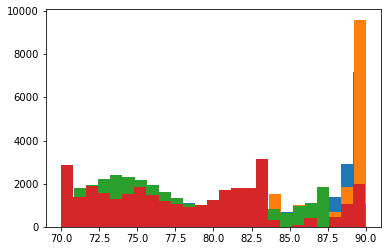

In [11]:

for trace in traces: 
    inc = pm.trace_to_dataframe(trace)['2_inc']
    
    plt.hist(90 - np.degrees(inc), bins=25)

In [12]:
import pickle

def load_trace(path):
    with open(path, 'rb') as buff: 
        trace = pickle.load(buff)
    return trace

In [14]:
from glob import glob

paths = glob('abdor_*.pkl')


traces = [load_trace(path) for path in paths]

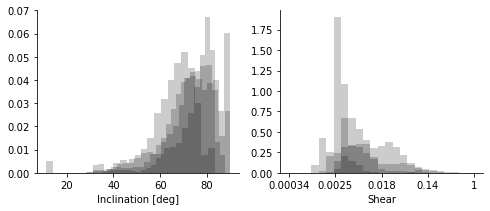

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for trace in traces:
    df = pm.trace_to_dataframe(trace)
    inc = df['2_inc']
    shear = df['2_ln_shear']
    ax[0].hist(90 - np.degrees(inc), 
                 bins=25,
                 alpha=0.2,
                 color='k', density=True)
    ax[1].hist(shear, 
                 bins=25,
                 alpha=0.2,
                 color='k', 
                 range=[-8, 0], density=True)

ax[1].set_xticklabels(["{:.2g}".format(np.exp(float(l))) 
                       for l in ax[1].get_xticks()])
ax[0].set_xlabel('Inclination [deg]')
ax[1].set_xlabel('Shear')

for axis in ax: 
    for sp in ['right', 'top']: 
        axis.spines[sp].set_visible(False)
fig.savefig('plots/abdor_shear.png', bbox_inches='tight', dpi=200)

In [ ]:
import healpy as hp

NSIDE = 2**8

NPIX = hp.nside2npix(NSIDE)

m = np.zeros(NPIX)

samples = pm.trace_to_dataframe(trace1).values

for lon, lat, rspot in np.median(samples[:, 4:], axis=0).reshape((n_spots, 3)):
    print(lon, lat)
    spot_vec = hp.ang2vec(np.pi - lat, lon)
    ipix_spots = hp.query_disc(nside=NSIDE, vec=spot_vec, radius=rspot)
    m[ipix_spots] = 1 - contrast

cmap = plt.cm.Greys
cmap.set_under('w')

hp.mollview(m, cbar=False, title="", cmap=cmap, hold=True,
            max=1.0, notext=True, flip='geo')
hp.graticule(color='silver')
plt.show()

In [ ]:

def model_numpy(f0, eq_period, shear, inclination, lon, lat, rspot):
#     nu = pm.Uniform("nu", lower=1, upper=5)    
    spot_model = 1 + f0 * np.ones(len(t1))
    #eq_period = pm.Uniform("P_eq", lower=0.2, upper=0.3)
#     eq_period = pm.Uniform("P_eq", lower=0.4, upper=0.6)
#     shear = pm.Uniform("shear", lower=0., upper=0.2)
#     inclination = 90-60
    
    for i in range(len(lon)):
        latitude_cutoff = 10
#         lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi)
#         lat = pm.Uniform(f"lat_{spot_ind}", lower=np.radians(latitude_cutoff), upper=np.radians(180-latitude_cutoff))
#         rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.1, upper=0.8)

        period_i = eq_period / (1 - shear * np.sin(lat[i] - np.pi/2)**2)
        phi = 2 * np.pi / period_i * (t1 - t1.mean()) - lon[i]

        spot_position_x = (np.cos(phi - np.pi/2) * np.sin(inclination) * np.sin(lat[i]) + 
                           np.cos(inclination) * np.cos(lat[i]))
        spot_position_y = -np.sin(phi - np.pi/2) * np.sin(lat[i])
        spot_position_z = (np.cos(lat[i]) * np.sin(inclination) - np.sin(phi) * 
                           np.cos(inclination) * np.sin(lat[i]))

        rsq = spot_position_x**2 + spot_position_y**2
        contrast = 0.4
        spot_model -= rspot[i]**2 * (1 - contrast) * np.where(spot_position_z > 0, np.sqrt(1 - rsq), 0)
    return spot_model 

In [ ]:
plt.figure(figsize=(20, 3))

for i in np.random.randint(0, samples.shape[0], size=100):
    f0, eq_period, shear, inclination = samples[i, :4]
    lon = samples[i, 4::3]
    lat = samples[i, 5::3]
    rspot = samples[i, 6::3]

    trial = model_numpy(f0, eq_period, shear, inclination, lon, lat, rspot)

    plt.plot(t1, trial, alpha=0.1, color='DodgerBlue')
    
plt.plot(t1, f1, 'k.')

plt.plot(t1, f1-trial + f1.mean() - 0.03, 'k.')

plt.xlabel('Time [d]')
plt.ylabel('Flux')
plt.savefig('plots/kepler411_fit.png', bbox_inches='tight', dpi=200)

In [ ]:
plt.hist(90-np.degrees(samples[:, 3]), bins=25)
plt.xlabel("Inclination [deg]")
plt.savefig('plots/kepler411_inc.png', bbox_inches='tight')

In [ ]:
np.save('k411_inc_1.npy', 90-np.degrees(samples[:, 3]))
np.save('k411_shear_1.npy', samples[:, 2])

In [ ]:
from glob import glob

incs = glob('k411_inc_*.npy')
shears = glob('k411_shear_*.npy')

fig, ax = plt.subplots(1, 2, figsize=(6, 2))

for p_inc, p_shear in zip(incs, shears):
    ax[0].hist(np.load(p_inc), bins=25, lw=3, histtype='step')
    ax[1].hist(np.load(p_shear), bins=25, lw=3, histtype='step')